In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alzheimer-diseases-3-class/3_cls/test/CONTROL/CONTROLAD_2673.png
/kaggle/input/alzheimer-diseases-3-class/3_cls/test/CONTROL/CONTROLAD_3188.png
/kaggle/input/alzheimer-diseases-3-class/3_cls/test/CONTROL/CONTROLAD_2713.png
/kaggle/input/alzheimer-diseases-3-class/3_cls/test/CONTROL/CONTROLAD_3104.png
/kaggle/input/alzheimer-diseases-3-class/3_cls/test/CONTROL/CONTROLAD_2642.png
/kaggle/input/alzheimer-diseases-3-class/3_cls/test/CONTROL/CONTROLAD_2586.png
/kaggle/input/alzheimer-diseases-3-class/3_cls/test/CONTROL/CONTROLAD_2745.png
/kaggle/input/alzheimer-diseases-3-class/3_cls/test/CONTROL/CONTROLAD_3038.png
/kaggle/input/alzheimer-diseases-3-class/3_cls/test/CONTROL/CONTROLAD_2819.png
/kaggle/input/alzheimer-diseases-3-class/3_cls/test/CONTROL/CONTROLAD_2737.png
/kaggle/input/alzheimer-diseases-3-class/3_cls/test/CONTROL/CONTROLAD_2697.png
/kaggle/input/alzheimer-diseases-3-class/3_cls/test/CONTROL/CONTROLAD_3119.png
/kaggle/input/alzheimer-diseases-3-class/3_cls/test/

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm 
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB7, EfficientNetB0, Xception
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import regularizers
from keras.saving import register_keras_serializable
from tensorflow.keras.layers import (Input, Dense, Dropout, LSTM, Flatten, TimeDistributed, RepeatVector, BatchNormalization,
MaxPooling2D, Conv2D, GlobalAveragePooling2D, GlobalAveragePooling1D, SpatialDropout2D, LayerNormalization, Concatenate,
Reshape, Multiply, Add, Bidirectional, Softmax, Attention, GRU, )
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from PIL import Image
from IPython.display import display, clear_output

2025-08-21 13:19:43.479985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755782383.663259      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755782383.715878      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
img_size =224
def crop_images(img, threshold=10):
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    mask = gray > threshold
    coords = np.argwhere(mask)
    if coords.size == 0:
        return img
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0) + 1
    return img[y0:y1, x0:x1]

In [4]:
def preprocess_images(img, img_size=(img_size, img_size)):
    img= crop_images(img)
    img=cv2.resize(img, img_size)
    # Tăng cường độ tương phản cho từng ảnh
    clahe = cv2.createCLAHE(clipLimit=25.0, tileGridSize=(4,4))
    img= cv2.cvtColor(cv2.merge((
        clahe.apply(cv2.split(cv2.cvtColor(cv2.resize(img, img_size), cv2.COLOR_BGR2LAB))[0]),
        *cv2.split(cv2.cvtColor(cv2.resize(img, img_size), cv2.COLOR_BGR2LAB))[1:])),
        cv2.COLOR_LAB2RGB)
    return img

In [5]:
def load_data(folder, img_size=(img_size, img_size)):
    images, labels = [], []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for img_name in tqdm(os.listdir(label_path), desc=f"Loading {label}"):
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = preprocess_images(img, img_size)
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

In [6]:
def show_sample_images(images, labels, num_samples=5):
    classes = np.unique(labels)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 5 * len(classes)))
    for i, class_label in enumerate(classes):
        class_images = [images[j] for j in range(len(labels)) if labels[j] == class_label]
        class_images = class_images[:num_samples]
        for j in range(num_samples):
            axes[i, j].imshow(class_images[j])
            axes[i, j].set_title(class_label)
            axes[i, j].axis("off")
    plt.show()

Loading AD: 100%|██████████| 639/639 [00:09<00:00, 68.01it/s]


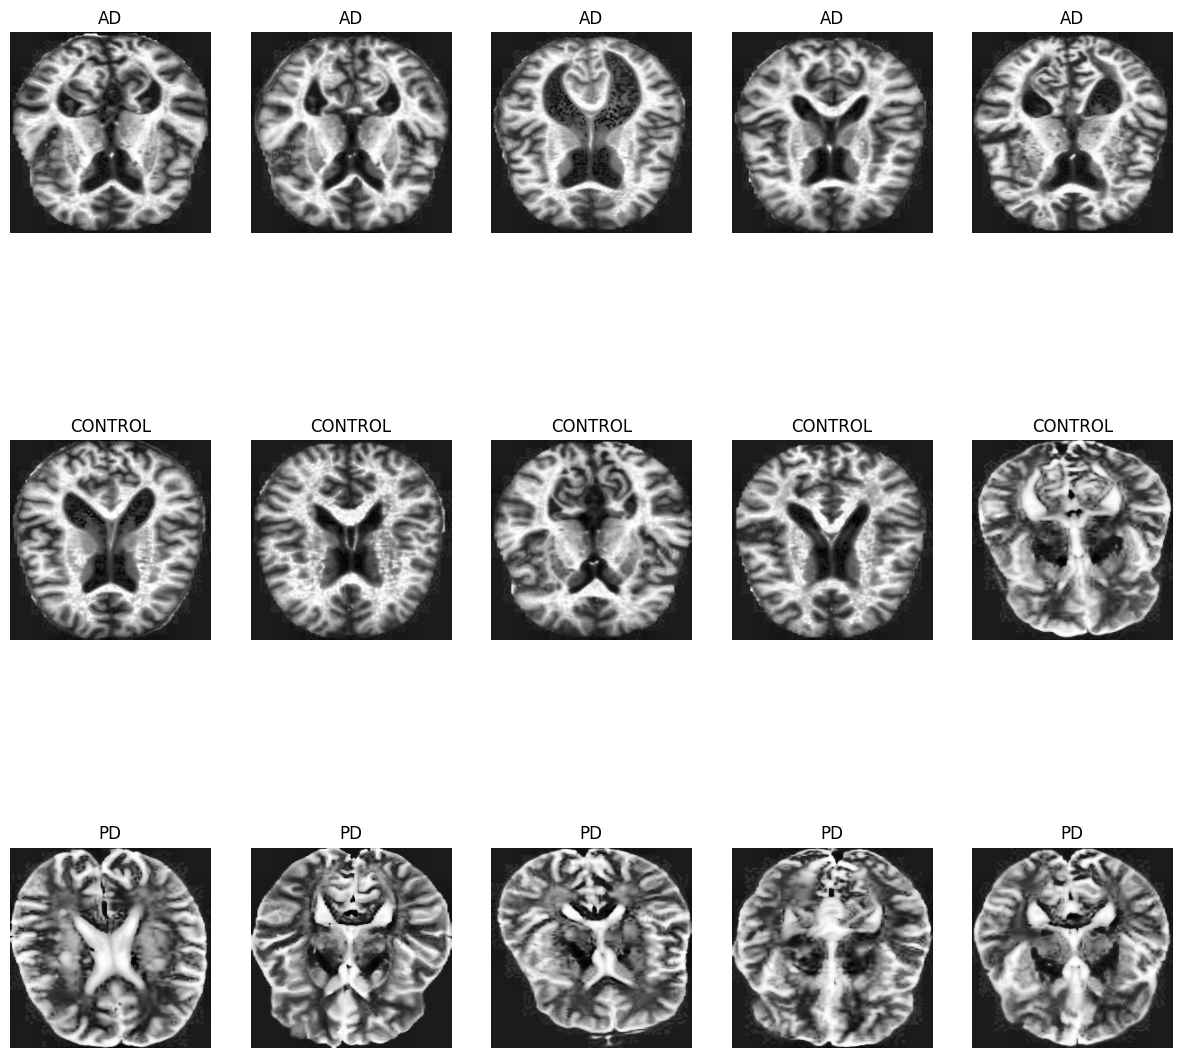

In [7]:
data_path = '/kaggle/input/alzheimer-diseases-3-class/3_cls'
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")
X_train, Y_train = load_data(train_path)
X_test, Y_test = load_data(test_path)
show_sample_images(X_train, Y_train)

In [8]:
# Check class distribution before balancing
label_counts_train = Counter(Y_train)
label_counts_test = Counter(Y_test)
print("Count of each class in the training set:", label_counts_train)
print("Count of each class in the test set:", label_counts_test)

Count of each class in the training set: Counter({'CONTROL': 3010, 'AD': 2561, 'PD': 906})
Count of each class in the test set: Counter({'CONTROL': 662, 'AD': 639, 'PD': 61})


In [9]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(6477, 224, 224, 3)
(6477,)
(1362, 224, 224, 3)
(1362,)


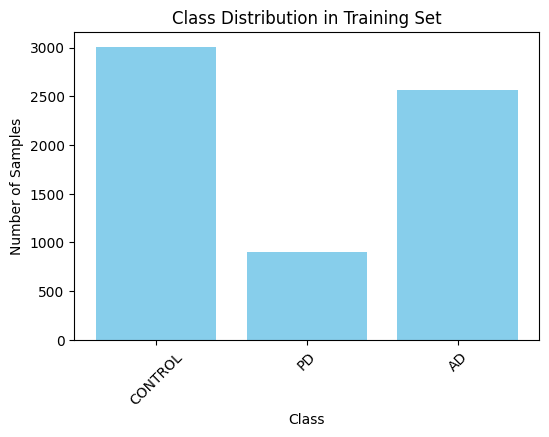

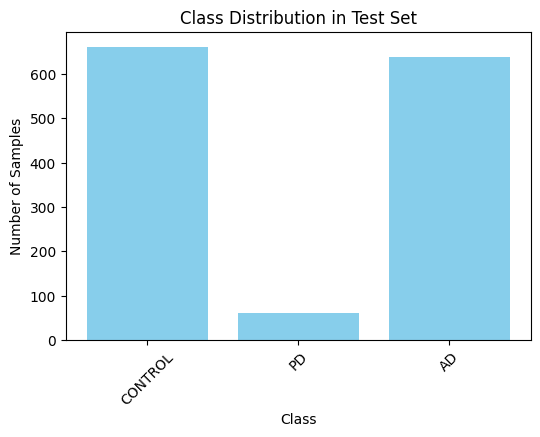

In [10]:
# Visualize class distribution
def plot_class_distribution(label_counts, title):
    plt.figure(figsize=(6,4))
    plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(label_counts_train, "Class Distribution in Training Set")
plot_class_distribution(label_counts_test, "Class Distribution in Test Set")

In [11]:
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X_train, Y_train,
    test_size=0.5,  # 50% of the data will be split further for validation and test
    random_state=42,
    stratify=Y_train,
    shuffle=True
)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp,
    test_size=0.5,  # Split ratio for validation:test = 25%:25%
    random_state=42,
    stratify=Y_temp,
    shuffle=True
)

In [12]:
total_size = len(X_train) + len(X_val) + len(X_test)
# Ratios for each set
train_ratio = len(X_train) / total_size
val_ratio = len(X_val) / total_size
test_ratio = len(X_test) / total_size

print("Training set ratio: ", round(train_ratio*100, 2))
print("Validation set ratio: ", round(val_ratio*100, 2))
print("Test set ratio: ", round(test_ratio*100, 2))

Training set ratio:  49.99
Validation set ratio:  25.0
Test set ratio:  25.01


In [13]:
# Convert labels to numerical format
unique_labels = sorted(set(Y_train))
label_map = {label: idx for idx, label in enumerate(unique_labels)}

Y_train = np.array([label_map[label] for label in Y_train], dtype=np.int64)
Y_val = np.array([label_map[label] for label in Y_val], dtype=np.int64)
Y_test = np.array([label_map[label] for label in Y_test], dtype=np.int64)

# Display the order of classes after normalization
print("\nOrder of classes after normalization:")
for label, idx in label_map.items():
    print(f"{idx}: {label}")

# One-hot encode the labels
Y_train = to_categorical(Y_train, num_classes=len(unique_labels))
Y_val = to_categorical(Y_val, num_classes=len(unique_labels))
Y_test = to_categorical(Y_test, num_classes=len(unique_labels))


Order of classes after normalization:
0: AD
1: CONTROL
2: PD


In [14]:
# Check the number of samples per class after splitting
label_counts_train = Counter(np.argmax(Y_train, axis=1))
label_counts_val = Counter(np.argmax(Y_val, axis=1))

print("Class distribution in training set after splitting:", label_counts_train)
print("Class distribution in validation set:", label_counts_val)

Class distribution in training set after splitting: Counter({1: 1505, 0: 1280, 2: 453})
Class distribution in validation set: Counter({1: 752, 0: 640, 2: 227})


In [15]:
# Check the number of samples per class after splitting
label_counts_train = Counter(np.argmax(Y_train, axis=1))
label_counts_val = Counter(np.argmax(Y_val, axis=1))

print("Class distribution in training set after splitting:", label_counts_train)
print("Class distribution in validation set:", label_counts_val)

Class distribution in training set after splitting: Counter({1: 1505, 0: 1280, 2: 453})
Class distribution in validation set: Counter({1: 752, 0: 640, 2: 227})


In [16]:
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
# Create a feature extractor model
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block6a_project_bn').output)
# Freeze the weights
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-300:]:
    layer.trainable = True
# Extract features from the dataset
X_train_features = feature_extractor.predict(X_train, batch_size=32, verbose=1)
X_val_features = feature_extractor.predict(X_val, batch_size=32, verbose=1)
X_test_features = feature_extractor.predict(X_test, batch_size=32, verbose=1)
# Display feature shapes
print("Shape of X_train_features:", X_train_features.shape)
print("Shape of X_val_features:", X_val_features.shape)
print("Shape of X_test_features:", X_test_features.shape)

I0000 00:00:1755782515.339240      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


I0000 00:00:1755782540.942103     102 service.cc:148] XLA service 0x7909080e41d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755782540.942867     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755782542.466714     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/102 ━━━━━━━━━━━━━━━━━━━━ 24:21 14s/step

I0000 00:00:1755782547.977757     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 238ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 216ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 218ms/step
Shape of X_train_features: (3238, 7, 7, 384)
Shape of X_val_features: (1619, 7, 7, 384)
Shape of X_test_features: (1620, 7, 7, 384)


In [17]:
# Display some sample features
print("Some sample features:")
print(X_train_features[:5])

Some sample features:
[[[[ 1.09082184e+01 -1.20705009e+00  5.63514948e-01 ...  5.59093428e+00
    -4.90808868e+00  1.24502504e+00]
   [ 5.35671175e-01 -3.19750738e+00  2.64922476e+00 ...  3.70881736e-01
     3.25009036e+00  1.31499517e+00]
   [ 3.15677953e+00 -2.67825961e+00  3.05693054e+00 ... -3.35928106e+00
     2.86223149e+00  1.05827439e+00]
   ...
   [ 1.51657522e+00 -3.84872389e+00  2.80411673e+00 ... -1.03296661e+00
     3.57673907e+00  2.84664536e+00]
   [ 1.87768507e+00 -4.22413921e+00 -2.79984641e+00 ...  1.91675746e+00
     1.34229136e+00  3.57191992e+00]
   [ 1.18726225e+01  1.53821981e+00  3.37779999e-01 ...  4.40520525e+00
    -5.90403414e+00  5.31686187e-01]]

  [[-3.05979276e+00 -4.55353069e+00  2.80689096e+00 ...  2.02215433e+00
     1.18660212e+00 -1.83080244e+00]
   [-1.25912094e+00 -1.65338516e+00  9.76349640e+00 ... -4.82224369e+00
     3.76110291e+00 -2.44803238e+00]
   [ 6.65346086e-01 -2.51163864e+00  5.02577972e+00 ... -2.39016700e+00
    -5.08830786e-01 -4.13

In [18]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization, LayerNormalization, Dropout, Multiply, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K

# Define the Squeeze-and-Excitation block
def se_block(inputs, reduction_ratio=16):
    channels = K.int_shape(inputs)[-1]  # Get the number of channels
    # Squeeze: Global Average Pooling across spatial dimensions
    x = GlobalAveragePooling2D()(inputs)
    # Excitation: Two fully connected layers
    x = Dense(channels // reduction_ratio, activation='relu')(x)
    x = Dense(channels, activation='sigmoid')(x)
    # Reshape to match input dimensions for scaling
    x = Reshape((1, 1, channels))(x)
    # Scale the input by multiplying with the excitation output
    x = Multiply()([inputs, x])
    return x

# Assuming unique_labels is defined (e.g., from previous code)
# Example: unique_labels = [0, 1, 2] (adjust based on your dataset)
unique_labels = [0, 1, 2]  # Replace with your actual unique labels

# Define the model
inputs = Input(shape=(7, 7, 384))
# Apply Squeeze-and-Excitation block
x = se_block(inputs)
x = GlobalAveragePooling2D()(x)

# Dense layers with decreasing dropout
x = Dense(512, activation='swish', kernel_regularizer=regularizers.l2(5e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='swish', kernel_regularizer=regularizers.l2(5e-4))(x)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='swish', kernel_regularizer=regularizers.l2(5e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='swish')(x)
x = LayerNormalization()(x)

# Output layer
outputs = Dense(len(unique_labels), activation='softmax')(x)
mlp_model = Model(inputs, outputs)

# Display model summary
mlp_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 7, 7, 384) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 384)       │          0 │ input_layer_1[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 24)        │      9,240 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 384)       │      9,600 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 384) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 7, 7, 384) │          0 │ input_layer_1[0]… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 384)       │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    197,120 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256)       │        512 │ dense_3[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_5[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 3)         │        195 │ layer_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 391,835 (1.49 MB)

 Trainable params: 390,555 (1.49 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Define the learning rate
learning_rate = 0.001  # You can adjust this value (e.g., 0.0001, 0.01)

# Compile the model
mlp_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add callbacks to prevent overfitting
checkpoint = ModelCheckpoint("mlp_model.keras",
                             monitor='val_loss',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)
tensorboard = TensorBoard(log_dir="logs")
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=7,
                               restore_best_weights=True, 
                               verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=3,
                              min_lr=1e-7,
                              verbose=1)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn.utils import class_weight
import numpy as np

# Assuming Y_train, Y_val, X_train_features, X_val_features are defined from your previous code
# Example class distribution from earlier: Counter({1: 1505, 0: 1280, 2: 453})

# Compute class weights
# Y_train.argmax(axis=1) converts one-hot encoded labels to class indices
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(Y_train, axis=1)),
    y=np.argmax(Y_train, axis=1)
)
class_weight_dict = {i: class_weights[i] for i in range(len(np.unique(np.argmax(Y_train, axis=1))))}
print("Class weights:", class_weight_dict)

# Compile the model (ensure learning_rate is defined)
learning_rate = 0.001  # From previous fix
mlp_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
checkpoint = ModelCheckpoint("mlp_model.keras",
                             monitor='val_loss',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)
tensorboard = TensorBoard(log_dir="logs")
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=7,
                               restore_best_weights=True,
                               verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=3,
                              min_lr=1e-7,
                              verbose=1)

# Train the model
history = mlp_model.fit(
    X_train_features, Y_train,
    validation_data=(X_val_features, Y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    verbose=1,
    callbacks=[checkpoint, tensorboard, reduce_lr, early_stopping]
)
mlp_model.save('/kaggle/working/mlp_model_final.keras')
print("MLP model saved to /kaggle/working/mlp_model_final.keras")

Class weights: {0: 0.8432291666666667, 1: 0.7171650055370986, 2: 2.382634289919058}
Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6012 - loss: 1.2504
Epoch 1: val_loss improved from inf to 1.07286, saving model to mlp_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.6022 - loss: 1.2477 - val_accuracy: 0.6881 - val_loss: 1.0729 - learning_rate: 0.0010
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7324 - loss: 0.9315
Epoch 2: val_loss improved from 1.07286 to 0.99248, saving model to mlp_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7324 - loss: 0.9315 - val_accuracy: 0.7468 - val_loss: 0.9925 - learning_rate: 0.0010
Epoch 3/100
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7762 - loss: 0.8556
Epoch 3: val_loss did not improve from 0.99248
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7758 - loss: 0.8560 - val_accuracy: 0.7035 - val_loss: 1.0751 - learning_rate: 0.0010
Epoch 4/100
51/51 ━━━━━━━━━━

In [21]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Define unique_labels with string class names
unique_labels = ['AD', 'CONTROL', 'PD']  # Matches your classification report output

# Make predictions on the test set
Y_pred = mlp_model.predict(X_test_features)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(Y_test_classes, Y_pred_classes, target_names=unique_labels))

# Print test accuracy
print("MLP Model Test Accuracy Score:", accuracy_score(Y_test_classes, Y_pred_classes))

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Classification Report:
              precision    recall  f1-score   support

          AD       0.93      0.92      0.93       641
     CONTROL       0.92      0.90      0.91       753
          PD       0.88      0.96      0.92       226

    accuracy                           0.92      1620
   macro avg       0.91      0.93      0.92      1620
weighted avg       0.92      0.92      0.92      1620

MLP Model Test Accuracy Score: 0.9191358024691358


[[592  49   0]
 [ 43 681  29]
 [  1   9 216]]


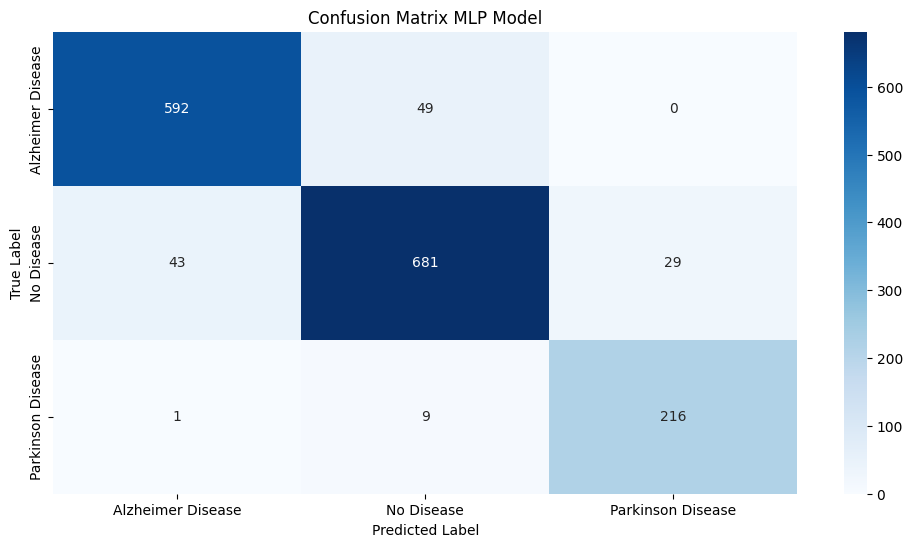

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(Y_test_classes, Y_pred_classes)
label_map = {0: 'Alzheimer Disease', 1: 'No Disease', 2: 'Parkinson Disease'}

# Plot heatmap of the confusion matrix
print(cm)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix MLP Model")
plt.show()

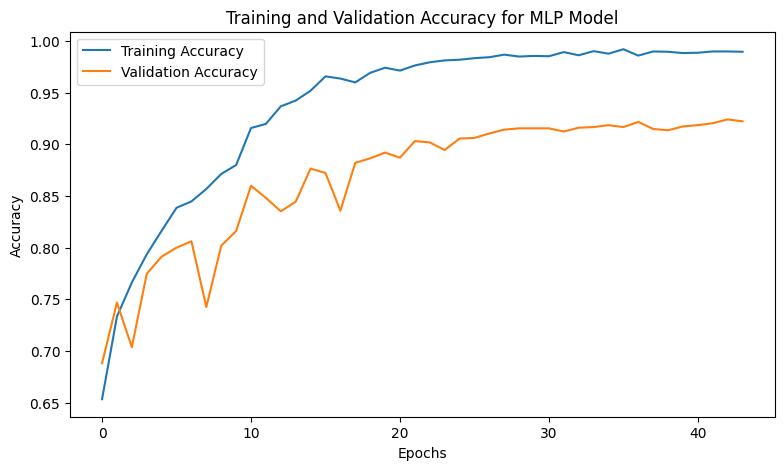

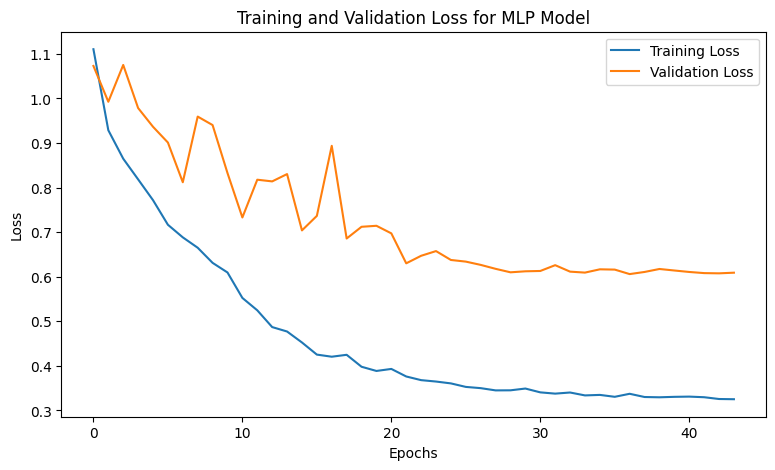

In [23]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy over Epochs
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for MLP Model')
plt.legend()
plt.show()

# Plot Training and Validation Loss over Epochs
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for MLP Model')
plt.legend()
plt.show()

In [24]:
inputs = Input(shape=(7, 7, 384))
x = se_block(inputs)

x = Conv2D(256, (3, 3), padding='same', activation='swish',
           kernel_regularizer=regularizers.l2(5e-4))(x)
x = BatchNormalization()(x)
x = SpatialDropout2D(0.25)(x)

x = Conv2D(128, (3, 3), padding='same', activation='swish',
           kernel_regularizer=regularizers.l2(5e-4))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.2)(x)

x = Conv2D(64, (3, 3), padding='same', activation='swish',
           kernel_regularizer=regularizers.l2(5e-4))(x)
x = BatchNormalization()(x)
x = SpatialDropout2D(0.15)(x)

x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='swish', kernel_regularizer=regularizers.l2(5e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='swish', kernel_regularizer=regularizers.l2(5e-4))(x)
x = Dropout(0.2)(x)

x = Dense(128, activation='swish')(x)

outputs = Dense(len(unique_labels), activation='softmax')(x)

cnn_model = Model(inputs, outputs)
cnn_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 7, 7, 384) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 384)       │          0 │ input_layer_2[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 24)        │      9,240 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 384)       │      9,600 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 384) │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 7, 7, 384) │          0 │ input_layer_2[0]… │
│ (Multiply)          │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 7, 7, 256) │    884,992 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 7, 7, 256) │          0 │ batch_normalizat… │
│ (SpatialDropout2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 128) │    295,040 │ spatial_dropout2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 3, 3, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_1 │ (None, 3, 3, 128) │          0 │ max_pooling2d[0]… │
│ (SpatialDropout2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 3, 3, 64)  │     73,792 │ spatial_dropout2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_2 │ (None, 3, 3, 64)  │          0 │ batch_normalizat… │
│ (SpatialDropout2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ spatial_dropout2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 512)       │     33,280 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 1,474,395 (5.62 MB)

 Trainable params: 1,472,475 (5.62 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [25]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

checkpoint = ModelCheckpoint("cnn_model.keras",
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)
tensorboard = TensorBoard(log_dir="logs")
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=3,
                               min_lr=1e-6,
                               verbose=1)

In [26]:
history = cnn_model.fit(
    X_train_features, Y_train,
    validation_data=(X_val_features, Y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict, 
    verbose=1,
    callbacks=[checkpoint,
               tensorboard,
               reduce_lr, 
               early_stopping])
history = cnn_model.fit(
    X_train_features, Y_train,
    validation_data=(X_val_features, Y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    verbose=1,
    callbacks=[checkpoint, tensorboard, reduce_lr, early_stopping]
)


Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5893 - loss: 1.2571
Epoch 1: val_loss improved from inf to 1.25166, saving model to cnn_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 0.5903 - loss: 1.2549 - val_accuracy: 0.5435 - val_loss: 1.2517 - learning_rate: 0.0010
Epoch 2/100
47/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7283 - loss: 1.0020
Epoch 2: val_loss improved from 1.25166 to 1.14348, saving model to cnn_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7282 - loss: 1.0013 - val_accuracy: 0.7412 - val_loss: 1.1435 - learning_rate: 0.0010
Epoch 3/100
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7511 - loss: 0.9494
Epoch 3: val_loss did not improve from 1.14348
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7512 - loss: 0.9487 - val_accuracy: 0.5973 - val_loss: 1.1493 - learning_rate: 0.0010
Epoch 4/100
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8134 - loss: 0.8454
Epoch 4: val_loss improve

In [27]:
Y_pred = cnn_model.predict(X_test_features)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)

print("Classification Report:")
print(classification_report(Y_test_classes, Y_pred_classes, target_names=unique_labels))
print("Accuracy_Test CNN Model Score:", accuracy_score(Y_test_classes, Y_pred_classes))

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Classification Report:
              precision    recall  f1-score   support

          AD       0.96      0.93      0.94       641
     CONTROL       0.92      0.93      0.92       753
          PD       0.88      0.92      0.90       226

    accuracy                           0.93      1620
   macro avg       0.92      0.93      0.92      1620
weighted avg       0.93      0.93      0.93      1620

Accuracy_Test CNN Model Score: 0.9271604938271605


[[596  45   0]
 [ 28 697  28]
 [  0  17 209]]


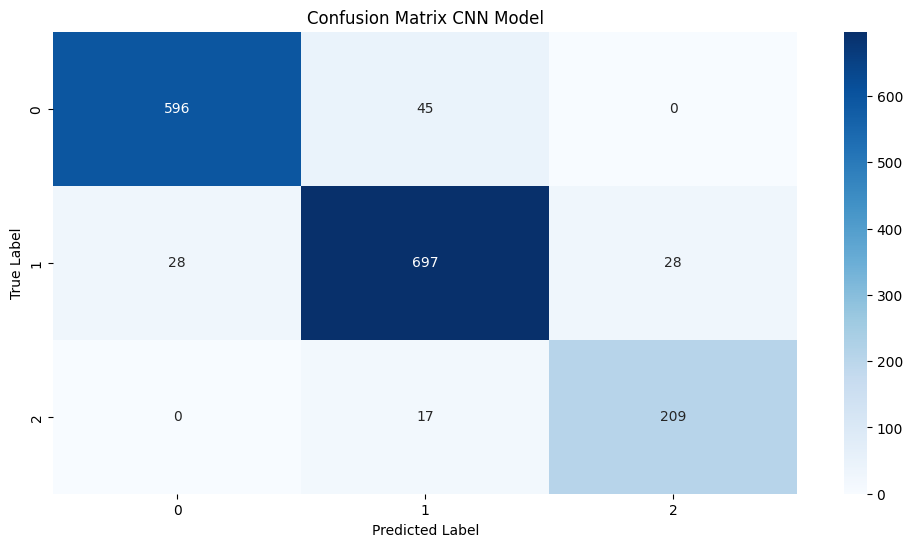

In [28]:
# Tạo confusion matrix
cm = confusion_matrix(Y_test_classes, Y_pred_classes)
label_map = {0: 'Alzheimer Disease', 1: 'No Disease', 2: 'Parkinson Disease'}
# Vẽ heatmap của confusion matrix
print(cm)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map, yticklabels=label_map)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CNN Model")
plt.show()

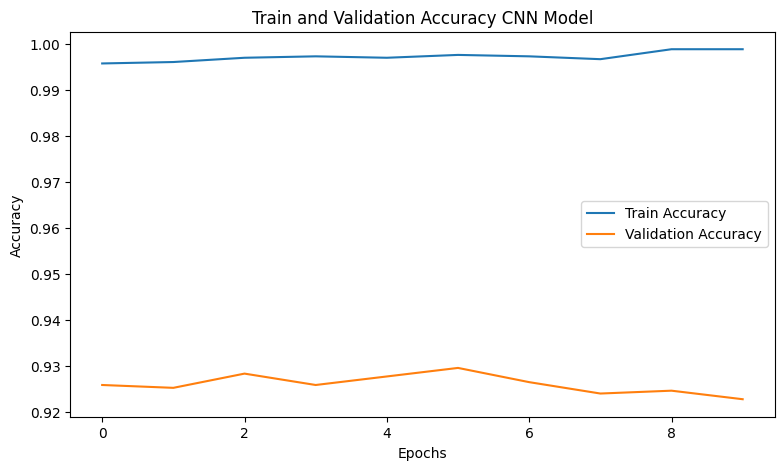

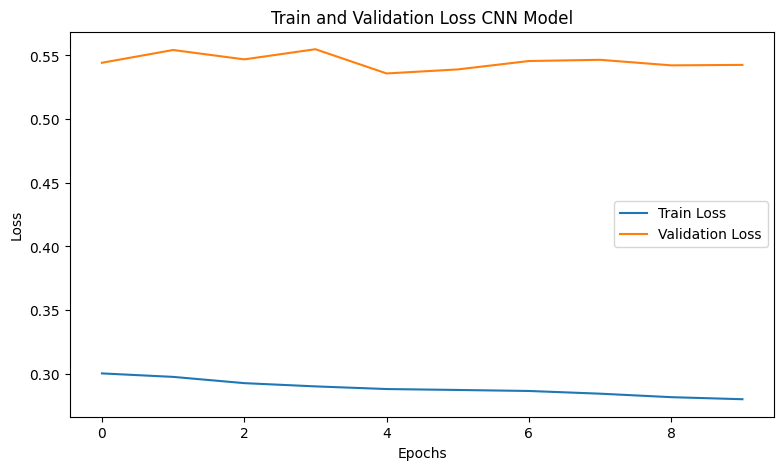

In [29]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy CNN Model')
plt.legend()
plt.show()
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss CNN Model')
plt.legend()
plt.show()

In [30]:
X_train_features = X_train_features.reshape(X_train_features.shape[0], 1, -1)
X_val_features = X_val_features.reshape(X_val_features.shape[0], 1, -1)
X_test_features = X_test_features.reshape(X_test_features.shape[0], 1, -1)

scaler = StandardScaler()
X_train_features_rnn = scaler.fit_transform(X_train_features.reshape(X_train_features.shape[0], -1)).reshape(X_train_features.shape)
X_val_features_rnn = scaler.transform(X_val_features.reshape(X_val_features.shape[0], -1)).reshape(X_val_features.shape)
X_test_features_rnn = scaler.transform(X_test_features.reshape(X_test_features.shape[0], -1)).reshape(X_test_features.shape)

print(X_train_features.shape)
print(X_val_features.shape)
print(X_test_features.shape)

(3238, 1, 18816)
(1619, 1, 18816)
(1620, 1, 18816)


In [31]:
lstm_model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(X_train_features.shape[1], X_train_features.shape[2])),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(512, activation='relu'),  # Tăng số lượng neurons
    Dropout(0.5),
    Dense(256, activation='relu'),  # Lớp Dense thứ hai
    Dropout(0.5),
    Dense(128, activation='relu'),  # Lớp Dense thứ ba
    Dropout(0.5),
    Dense(len(unique_labels), activation='softmax')  # Lớp output
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])
# Thêm callbacks để tránh overfitting
checkpoint = ModelCheckpoint("lstm_model.keras",
                             monitor='val_loss',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)
tensorboard = TensorBoard(log_dir="logs")
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True, 
                               verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=2,
                              min_lr=1e-7,
                              verbose=1)

In [33]:
history = lstm_model.fit(
    X_train_features, Y_train,
    validation_data=(X_val_features, Y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict, 
    verbose=1,
    callbacks=[checkpoint,
               tensorboard,
               reduce_lr, 
               early_stopping])
lstm_model.save('/kaggle/working/lstm_model_final.keras')
print("LSTM model saved to /kaggle/working/lstm_model_final.keras")

Epoch 1/100
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3714 - loss: 1.1020
Epoch 1: val_loss improved from inf to 1.09280, saving model to lstm_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.3698 - loss: 1.1024 - val_accuracy: 0.4645 - val_loss: 1.0928 - learning_rate: 0.0010
Epoch 2/100
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3394 - loss: 1.1022
Epoch 2: val_loss improved from 1.09280 to 1.07935, saving model to lstm_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.3394 - loss: 1.1019 - val_accuracy: 0.5355 - val_loss: 1.0794 - learning_rate: 0.0010
Epoch 3/100
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4417 - loss: 0.9861
Epoch 3: val_loss improved from 1.07935 to 0.76112, saving model to lstm_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4429 - loss: 0.9823 - val_accuracy: 0.5343 - val_loss: 0.7611 - learning_rate: 0.0010
Epoch 4/100
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5275 

In [34]:
Y_pred = lstm_model.predict(X_test_features)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)

print("Classification Report:")
print(classification_report(Y_test_classes, Y_pred_classes, target_names=unique_labels))
print("Accuracy_Test RNN Model Score:", accuracy_score(Y_test_classes, Y_pred_classes))

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report:
              precision    recall  f1-score   support

          AD       0.50      1.00      0.67       641
     CONTROL       0.00      0.00      0.00       753
          PD       0.66      1.00      0.79       226

    accuracy                           0.54      1620
   macro avg       0.39      0.67      0.49      1620
weighted avg       0.29      0.54      0.38      1620

Accuracy_Test RNN Model Score: 0.5351851851851852


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[641   0   0]
 [634   0 119]
 [  0   0 226]]


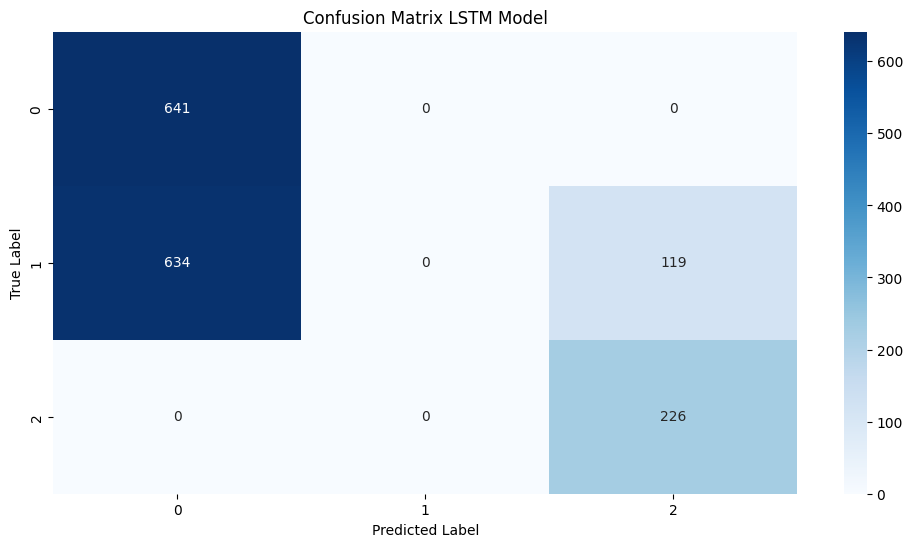

In [35]:
cm = confusion_matrix(Y_test_classes, Y_pred_classes)
label_map = {0: 'Alzheimer Disease', 1: 'No Disease', 2: 'Parkinson Disease'}
# Vẽ heatmap của confusion matrix
print(cm)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map, yticklabels=label_map)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix LSTM Model")
plt.show()

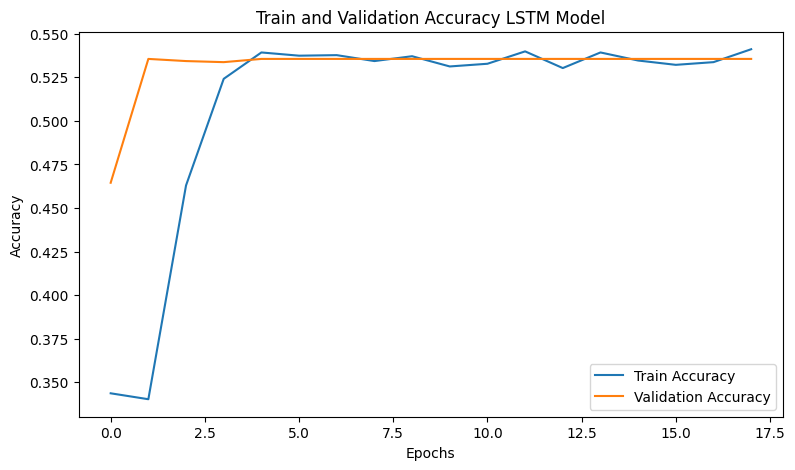

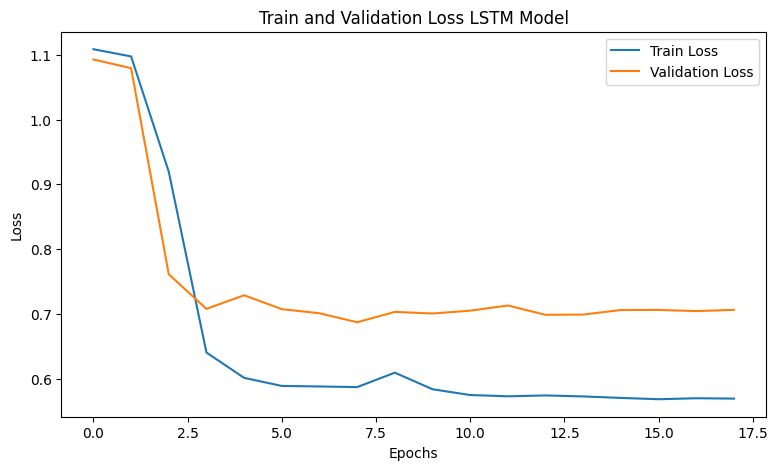

In [36]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy LSTM Model')
plt.legend()
plt.show()
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss LSTM Model')
plt.legend()

plt.show()

In [37]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input

# Function to predict images in a folder
def predict_images(model, folder_path, label_map, feature_extractor):
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)
            # Extract features from the image
            feature = feature_extractor.predict(img, verbose=0)
            # Predict label
            prediction = model.predict(feature, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]
            predicted_label = label_map[predicted_class]
            print(f"Image: {image_file} - Predicted: {predicted_label}")

# Load the trained model
model = load_model('/kaggle/working/cnn_model.keras')

# Load EfficientNetB7 as base model
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Reverse mapping: from class index to label name
reverse_label_map = {v: k for k, v in label_map.items()}

# Create feature extractor from a specific EfficientNetB7 layer
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block6a_project_bn').output)

# Path to the folder of images to predict
folder_path = "/kaggle/input/alzheimer-diseases-3-class/3_cls/test/AD"

predict_images(model, folder_path, label_map, feature_extractor)
print("Done!")


Image: AD_2675.png - Predicted: No Disease
Image: AD_3168.png - Predicted: Alzheimer Disease
Image: AD_2829.png - Predicted: Alzheimer Disease
Image: AD_3009.png - Predicted: No Disease
Image: AD_3092.png - Predicted: No Disease
Image: AD_3088.png - Predicted: Alzheimer Disease
Image: AD_3146.png - Predicted: Alzheimer Disease
Image: AD_2924.png - Predicted: Alzheimer Disease
Image: AD_3035.png - Predicted: Alzheimer Disease
Image: AD_2810.png - Predicted: Alzheimer Disease
Image: AD_3134.png - Predicted: No Disease
Image: AD_2841.png - Predicted: Alzheimer Disease
Image: AD_3006.png - Predicted: Alzheimer Disease
Image: AD_2812.png - Predicted: Alzheimer Disease
Image: AD_3155.png - Predicted: Alzheimer Disease
Image: AD_2643.png - Predicted: Alzheimer Disease
Image: AD_2897.png - Predicted: Alzheimer Disease
Image: AD_2793.png - Predicted: Alzheimer Disease
Image: AD_3067.png - Predicted: Alzheimer Disease
Image: AD_2797.png - Predicted: Alzheimer Disease
Image: AD_2694.png - Predict

2025-08-21 15:00:27.551419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755788427.730409      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755788427.791954      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1755788500.449715      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1755788513.336663      96 service.cc:148] XLA service 0x7fb8e4104d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755788513.337224      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755788513.456685      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/162 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step

I0000 00:00:1755788520.946255      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


162/162 ━━━━━━━━━━━━━━━━━━━━ 26s 110ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step
VGG16 Features: (5181, 7, 7, 512)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 | D Loss: [0.2785418 0.84375  ] | G Loss: 0.7010362148284912
Epoch 50 | D Loss: [20.95359     0.48461765] | G Loss: 0.013749267905950546
Epoch 100 | D Loss: [23.09422    0.4782908] | G Loss: 0.006942699663341045
Epoch 150 | D Loss: [23.821371    0.47792423] | G Loss: 0.004643792286515236
Epoch 200 | D Loss: [24.185349    0.47703996] | G Loss: 0.0034886200446635485
Epoch 250 | D Loss: [24.405315   0.4766954] | G Loss: 0.0027936759870499372
Epoch 300 | D Loss: [24.555527   0.4762576] | G Loss: 0.0023296100553125143
Epoch 350 | D Loss: [24.659222   0.4762565] | G Loss: 0.0019977567717432976
Epoch 400 | D Loss: [24.734997    0.47633362] | G Loss: 0.0017486599972471595
Epoch 450 | D Loss: [24.79912   0.476359] | G Loss: 0.0015547951916232705
Augmented Data: (5681, 7, 7, 512) (5681, 3)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,891 (648.01 KB)

 Trainable params: 165,379 (646.01 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5831 - loss: 0.9054
Epoch 1: val_loss improved from inf to 0.54250, saving model to mlp_vgg16_gan.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5838 - loss: 0.9034 - val_accuracy: 0.7307 - val_loss: 0.5425
Epoch 2/50
78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7282 - loss: 0.5540
Epoch 2: val_loss improved from 0.54250 to 0.50217, saving model to mlp_vgg16_gan.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7280 - loss: 0.5542 - val_accuracy: 0.7485 - val_loss: 0.5022
Epoch 3/50
76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7337 - loss: 0.5162
Epoch 3: val_loss did not improve from 0.50217
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7364 - loss: 0.5148 - val_accuracy: 0.7724 - val_loss: 0.5030
Epoch 4/50
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7832 - loss: 0.4465
Epoch 4: val_loss improved from 0.50217 to 0.43077, saving model to mlp_vgg16_gan.keras
89/89 ━━━━

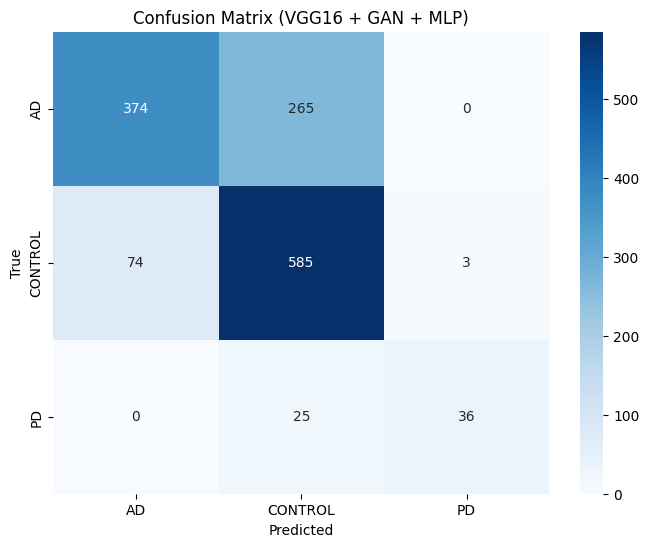

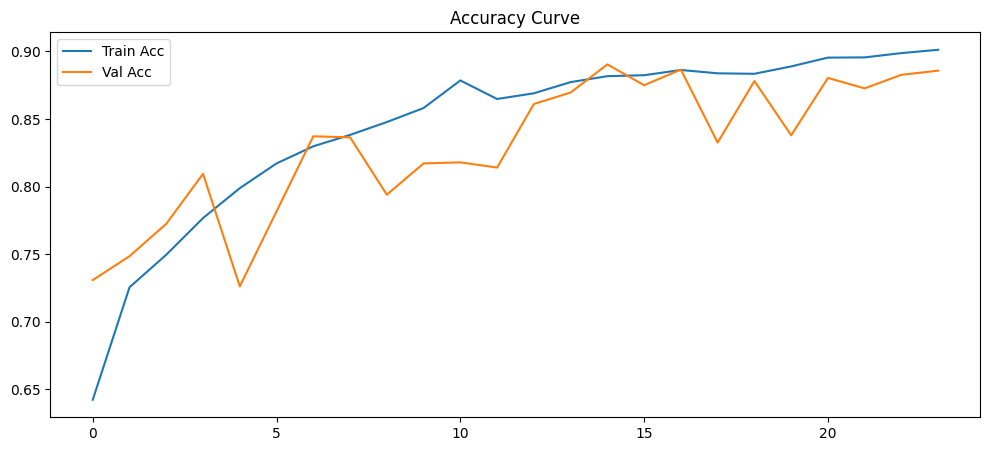

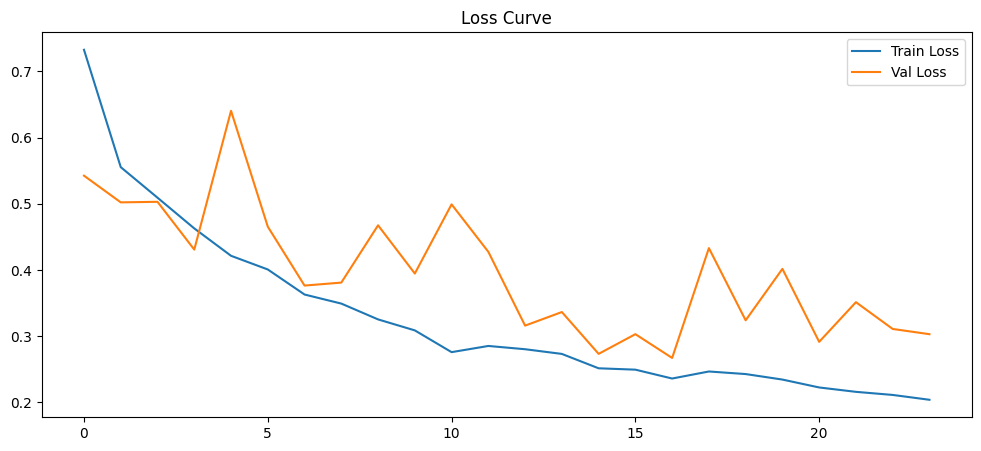

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization, LayerNormalization,
                                     GlobalAveragePooling2D, Multiply, Reshape)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

# ============================================================
# STEP 1: Load Data
# ============================================================
img_size = 224
data_path = '/kaggle/input/alzheimer-diseases-3-class/3_cls'
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")

def load_data(folder, img_size=(img_size, img_size)):
    images, labels = [], []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

X_train, Y_train = load_data(train_path)
X_test, Y_test = load_data(test_path)

# Split train into train/val
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=42
)

# Label mapping
unique_labels = sorted(set(Y_train))
label_map = {label: idx for idx, label in enumerate(unique_labels)}
reverse_label_map = {v: k for k, v in label_map.items()}

Y_train = np.array([label_map[label] for label in Y_train])
Y_val = np.array([label_map[label] for label in Y_val])
Y_test = np.array([label_map[label] for label in Y_test])

Y_train = to_categorical(Y_train, num_classes=len(unique_labels))
Y_val = to_categorical(Y_val, num_classes=len(unique_labels))
Y_test = to_categorical(Y_test, num_classes=len(unique_labels))

# ============================================================
# STEP 2: Feature Extractor (VGG16)
# ============================================================
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer("block5_pool").output)

X_train_features = feature_extractor.predict(preprocess_input(X_train), batch_size=32, verbose=1)
X_val_features = feature_extractor.predict(preprocess_input(X_val), batch_size=32, verbose=1)
X_test_features = feature_extractor.predict(preprocess_input(X_test), batch_size=32, verbose=1)

print("VGG16 Features:", X_train_features.shape)

# ============================================================
# STEP 3: Simple GAN for Synthetic Data
# ============================================================
latent_dim = 100
channels = X_train_features.shape[-1]
feat_shape = (X_train_features.shape[1], X_train_features.shape[2], channels)

# Generator
generator = Sequential([
    Dense(256, activation="relu", input_dim=latent_dim),
    Dense(np.prod(feat_shape), activation="tanh"),
    Reshape(feat_shape)
])

# Discriminator
discriminator = Sequential([
    Flatten(input_shape=feat_shape),
    Dense(256, activation="relu"),
    Dense(1, activation="sigmoid")
])

discriminator.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# GAN Model
discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
fake_features = generator(gan_input)
gan_output = discriminator(fake_features)
gan = Model(gan_input, gan_output)
gan.compile(optimizer="adam", loss="binary_crossentropy")

# Train GAN (small number of epochs for augmentation)
epochs = 500
batch_size = 32
for epoch in range(epochs):
    idx = np.random.randint(0, X_train_features.shape[0], batch_size)
    real = X_train_features[idx]
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake = generator.predict(noise, verbose=0)

    d_loss_real = discriminator.train_on_batch(real, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake, np.zeros((batch_size, 1)))
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 50 == 0:
        print(f"Epoch {epoch} | D Loss: {0.5 * np.add(d_loss_real, d_loss_fake)} | G Loss: {g_loss}")

# Generate synthetic features
noise = np.random.normal(0, 1, (500, latent_dim))
synthetic_features = generator.predict(noise, verbose=0)
synthetic_labels = np.random.randint(0, len(unique_labels), 500)
synthetic_labels_onehot = to_categorical(synthetic_labels, num_classes=len(unique_labels))

# Combine synthetic + real
X_train_aug = np.concatenate([X_train_features, synthetic_features], axis=0)
Y_train_aug = np.concatenate([Y_train, synthetic_labels_onehot], axis=0)

print("Augmented Data:", X_train_aug.shape, Y_train_aug.shape)

# ============================================================
# STEP 4: MLP Classifier
# ============================================================
inputs = Input(shape=feat_shape)
x = GlobalAveragePooling2D()(inputs)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = LayerNormalization()(x)
x = Dense(len(unique_labels), activation="softmax")(x)

mlp_model = Model(inputs, x)
mlp_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
mlp_model.summary()

# Train
checkpoint = ModelCheckpoint("mlp_vgg16_gan.keras", monitor="val_loss", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True, verbose=1)

history = mlp_model.fit(
    X_train_aug, Y_train_aug,
    validation_data=(X_val_features, Y_val),
    epochs=50,
    batch_size=64,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

# ============================================================
# STEP 5: Evaluation
# ============================================================
Y_pred = mlp_model.predict(X_test_features)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)

print("Classification Report:")
print(classification_report(Y_test_classes, Y_pred_classes, target_names=unique_labels))
print("Accuracy:", accuracy_score(Y_test_classes, Y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(Y_test_classes, Y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (VGG16 + GAN + MLP)")
plt.show()

# Training Curves
plt.figure(figsize=(12,5))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()


In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# -----------------------------
# GPU if available
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# -----------------------------
# Paths
# -----------------------------
train_path = "/kaggle/input/alzheimer-diseases-3-class/3_cls/train"
test_path  = "/kaggle/input/alzheimer-diseases-3-class/3_cls/test"

# -----------------------------
# Data Augmentation
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# -----------------------------
# Load dataset
# -----------------------------
full_train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

# Split train into train + val (80% train, 20% val)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("✅ Dataset loaded:")
print("Train:", len(train_dataset), " | Val:", len(val_dataset), " | Test:", len(test_dataset))

# -----------------------------
# Model: Pretrained ResNet18
# -----------------------------
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)   # 3 classes
model = model.to(device)

# -----------------------------
# Loss & Optimizer
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# -----------------------------
# Training Loop
# -----------------------------
epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    val_acc = 0
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
        val_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

# -----------------------------
# Test Accuracy
# -----------------------------
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

print(f"✅ Test Accuracy: {100*correct/total:.2f}%")

# -----------------------------
# Save Model
# -----------------------------
torch.save(model.state_dict(), "alzheimers_resnet18.pth")
print("💾 Model saved as alzheimers_resnet18.pth")


✅ Using device: cuda
✅ Dataset loaded:
Train: 5181  | Val: 1296  | Test: 1362


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 198MB/s]
Epoch 1/15: 100%|██████████| 162/162 [00:37<00:00,  4.31it/s]


Epoch 1/15 | Loss: 0.5651 | Train Acc: 73.09% | Val Acc: 60.88%


Epoch 2/15: 100%|██████████| 162/162 [00:24<00:00,  6.72it/s]


Epoch 2/15 | Loss: 0.4025 | Train Acc: 81.99% | Val Acc: 73.23%


Epoch 3/15: 100%|██████████| 162/162 [00:23<00:00,  6.96it/s]


Epoch 3/15 | Loss: 0.3120 | Train Acc: 86.68% | Val Acc: 75.15%


Epoch 4/15: 100%|██████████| 162/162 [00:24<00:00,  6.69it/s]


Epoch 4/15 | Loss: 0.2335 | Train Acc: 90.74% | Val Acc: 87.11%


Epoch 5/15: 100%|██████████| 162/162 [00:24<00:00,  6.58it/s]


Epoch 5/15 | Loss: 0.1756 | Train Acc: 93.21% | Val Acc: 86.57%


Epoch 6/15: 100%|██████████| 162/162 [00:23<00:00,  6.82it/s]


Epoch 6/15 | Loss: 0.1398 | Train Acc: 94.81% | Val Acc: 90.97%


Epoch 7/15: 100%|██████████| 162/162 [00:23<00:00,  6.86it/s]


Epoch 7/15 | Loss: 0.0963 | Train Acc: 96.27% | Val Acc: 87.58%


Epoch 8/15: 100%|██████████| 162/162 [00:23<00:00,  6.79it/s]


Epoch 8/15 | Loss: 0.0893 | Train Acc: 96.60% | Val Acc: 90.74%


Epoch 9/15: 100%|██████████| 162/162 [00:23<00:00,  6.89it/s]


Epoch 9/15 | Loss: 0.0790 | Train Acc: 96.93% | Val Acc: 88.35%


Epoch 10/15: 100%|██████████| 162/162 [00:23<00:00,  6.82it/s]


Epoch 10/15 | Loss: 0.0630 | Train Acc: 97.84% | Val Acc: 96.45%


Epoch 11/15: 100%|██████████| 162/162 [00:23<00:00,  6.82it/s]


Epoch 11/15 | Loss: 0.0667 | Train Acc: 97.61% | Val Acc: 94.98%


Epoch 12/15: 100%|██████████| 162/162 [00:24<00:00,  6.73it/s]


Epoch 12/15 | Loss: 0.0594 | Train Acc: 97.65% | Val Acc: 84.88%


Epoch 13/15: 100%|██████████| 162/162 [00:24<00:00,  6.70it/s]


Epoch 13/15 | Loss: 0.0585 | Train Acc: 97.74% | Val Acc: 93.44%


Epoch 14/15: 100%|██████████| 162/162 [00:23<00:00,  6.76it/s]


Epoch 14/15 | Loss: 0.0357 | Train Acc: 98.69% | Val Acc: 96.99%


Epoch 15/15: 100%|██████████| 162/162 [00:24<00:00,  6.70it/s]


Epoch 15/15 | Loss: 0.0376 | Train Acc: 98.82% | Val Acc: 86.81%
✅ Test Accuracy: 68.94%
💾 Model saved as alzheimers_resnet18.pth


Epoch 1/30 | Loss: 0.0482 | Train Acc: 98.34% | Val Acc: 96.45%
Epoch 2/30 | Loss: 0.0344 | Train Acc: 98.80% | Val Acc: 96.30%
Epoch 3/30 | Loss: 0.0266 | Train Acc: 99.13% | Val Acc: 93.36%
Epoch 4/30 | Loss: 0.0447 | Train Acc: 98.38% | Val Acc: 96.76%
Epoch 5/30 | Loss: 0.0347 | Train Acc: 98.69% | Val Acc: 96.30%
Epoch 6/30 | Loss: 0.0257 | Train Acc: 99.03% | Val Acc: 94.37%
Epoch 7/30 | Loss: 0.0292 | Train Acc: 98.90% | Val Acc: 93.83%
Epoch 8/30 | Loss: 0.0333 | Train Acc: 98.75% | Val Acc: 94.75%
Epoch 9/30 | Loss: 0.0368 | Train Acc: 98.78% | Val Acc: 95.06%
Epoch 10/30 | Loss: 0.0342 | Train Acc: 98.69% | Val Acc: 96.84%
Epoch 11/30 | Loss: 0.0213 | Train Acc: 99.31% | Val Acc: 97.22%
Epoch 12/30 | Loss: 0.0236 | Train Acc: 99.19% | Val Acc: 96.37%
Epoch 13/30 | Loss: 0.0202 | Train Acc: 99.44% | Val Acc: 97.22%
Epoch 14/30 | Loss: 0.0191 | Train Acc: 99.15% | Val Acc: 96.37%
Epoch 15/30 | Loss: 0.0200 | Train Acc: 99.38% | Val Acc: 96.99%
Epoch 16/30 | Loss: 0.0195 | Train

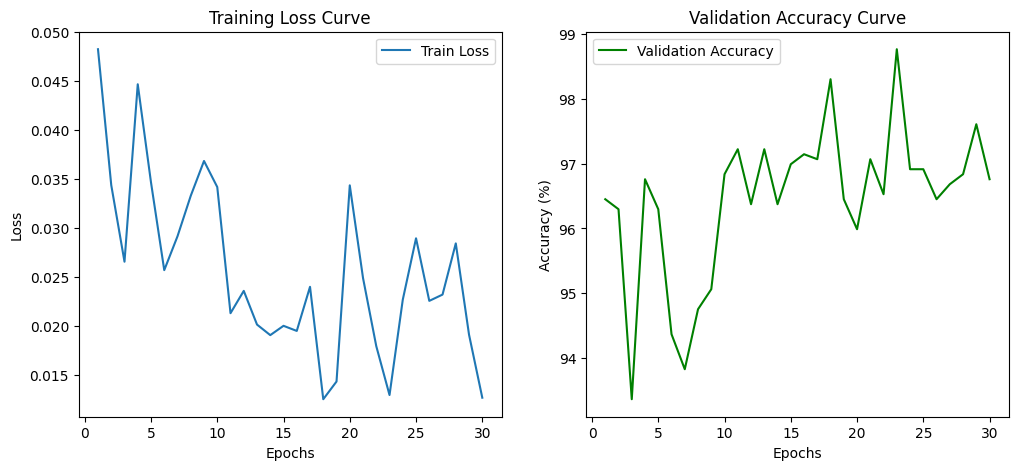


📊 Classification Report:
              precision    recall  f1-score   support

          AD       0.81      0.88      0.84       639
     CONTROL       0.83      0.80      0.81       662
          PD       1.00      0.46      0.63        61

    accuracy                           0.82      1362
   macro avg       0.88      0.71      0.76      1362
weighted avg       0.83      0.82      0.82      1362



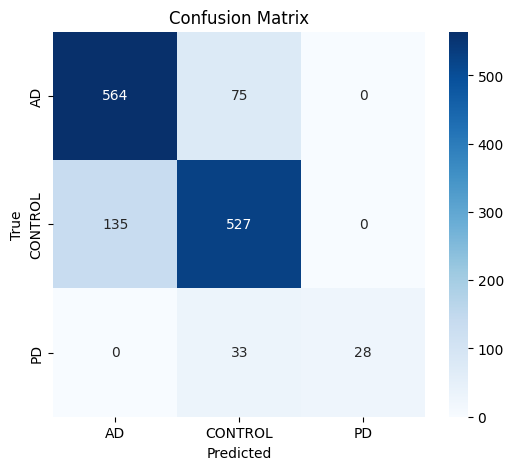

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# -----------------------------
# 1. Plot Training Curves
train_losses, val_accs = [], []

epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_losses.append(running_loss/len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
        val_acc = 100 * correct / total
        val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

# Plot Curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,epochs+1), train_losses, label="Train Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.title("Training Loss Curve"); plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,epochs+1), val_accs, label="Validation Accuracy", color="green")
plt.xlabel("Epochs"); plt.ylabel("Accuracy (%)"); plt.title("Validation Accuracy Curve"); plt.legend()
plt.show()

# -----------------------------
# 2. Confusion Matrix + Report
# -----------------------------
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()


In [13]:
# 2. Confusion Matrix + Report
# -----------------------------
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



📊 Classification Report:
              precision    recall  f1-score   support

          AD       0.81      0.88      0.84       639
     CONTROL       0.83      0.80      0.81       662
          PD       1.00      0.46      0.63        61

    accuracy                           0.82      1362
   macro avg       0.88      0.71      0.76      1362
weighted avg       0.83      0.82      0.82      1362



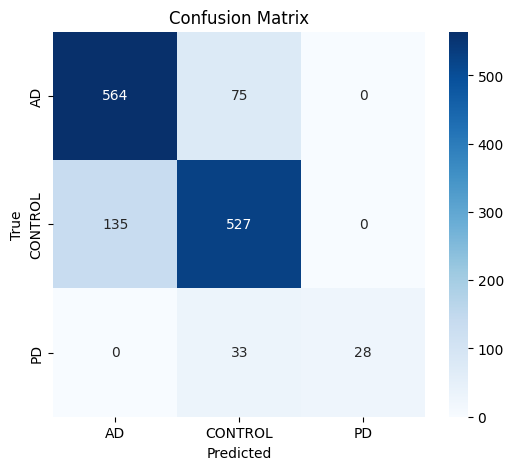

In [14]:
# Classification report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()


📌 Evaluation Metrics Equations (for paper):

1. Accuracy = (TP + TN) / (TP + TN + FP + FN)
2. Precision = TP / (TP + FP)
3. Recall = TP / (TP + FN)
4. F1 = 2 * (Precision * Recall) / (Precision + Recall)
5. ROC-AUC = ∫ TPR(FPR) d(FPR)
6. Loss = - 1/N Σ [ y log(ŷ) + (1-y) log(1-ŷ) ]

📊 Classification Report:
              precision    recall  f1-score   support

          AD       0.81      0.88      0.84       639
     CONTROL       0.83      0.80      0.81       662
          PD       1.00      0.46      0.63        61

    accuracy                           0.82      1362
   macro avg       0.88      0.71      0.76      1362
weighted avg       0.83      0.82      0.82      1362



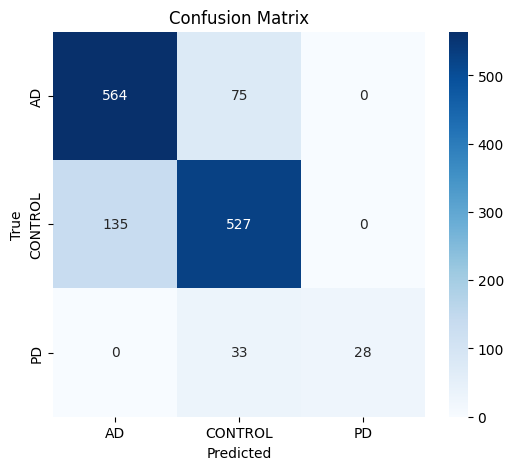

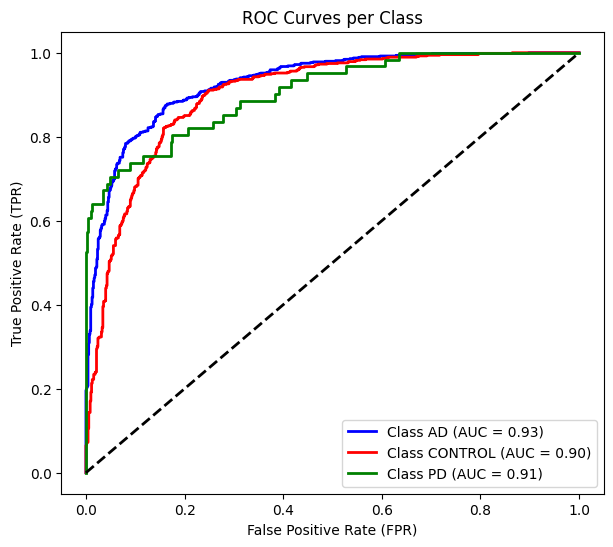

✅ Average ROC-AUC: 0.911


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import torch.nn.functional as F

# -----------------------------
# 1. Evaluate on Test Set
# -----------------------------
all_preds, all_labels, all_probs = [], [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)

        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# -----------------------------
# 2. Print Equations for Paper
# -----------------------------
print("\n📌 Evaluation Metrics Equations (for paper):\n")
print("1. Accuracy = (TP + TN) / (TP + TN + FP + FN)")
print("2. Precision = TP / (TP + FP)")
print("3. Recall = TP / (TP + FN)")
print("4. F1 = 2 * (Precision * Recall) / (Precision + Recall)")
print("5. ROC-AUC = ∫ TPR(FPR) d(FPR)")
print("6. Loss = - 1/N Σ [ y log(ŷ) + (1-y) log(1-ŷ) ]")

# -----------------------------
# 3. Classification Report
# -----------------------------
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# -----------------------------
# 4. Confusion Matrix
# -----------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# -----------------------------
# 5. ROC-AUC Curve (multi-class, one-vs-rest)
# -----------------------------
from sklearn.preprocessing import label_binarize
from itertools import cycle

n_classes = len(test_dataset.classes)
y_test_bin = label_binarize(all_labels, classes=list(range(n_classes)))
fpr, tpr, roc_auc = dict(), dict(), dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], all_probs[:, i])

colors = cycle(["blue", "red", "green"])
plt.figure(figsize=(7,6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {test_dataset.classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],"k--",lw=2)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves per Class")
plt.legend(loc="lower right")
plt.show()

# -----------------------------
# 6. Average ROC-AUC
# -----------------------------
avg_auc = np.mean(list(roc_auc.values()))
print(f"✅ Average ROC-AUC: {avg_auc:.3f}")

# -----------------------------
# 7. (Optional) Grad-CAM placeholder
# -----------------------------


In [16]:
# -----------------------------
# 8. Save the Trained Model
# -----------------------------
import torch

# حفظ وزن الموديل
torch.save(model.state_dict(), "alzheimers_resnet18.pth")

print("✅ Model saved as alzheimers_resnet18.pth — now you can download it and use in Streamlit")


✅ Model saved as alzheimers_resnet18.pth — now you can download it and use in Streamlit
